# MNIST読み込み

In [1]:
nb_train, nb_val = 50000, 10000

In [2]:
import numpy as np
from sklearn.utils import shuffle

f = np.load('../AutoEncoder/mnist.npz')
X = f['x_train'] / 255.
Y = f['y_train']
x_train = X[:nb_train]
y_train = Y[:nb_train]
x_val = X[nb_train:nb_train+nb_val]
y_val = Y[nb_train:nb_train+nb_val]
x_test = f['x_test'] / 255.
y_test = f['y_test']

def batch_flatten(X):
    return np.reshape(X, (len(X), np.prod(X.shape[1:])))
    
x_train = batch_flatten(x_train)
x_val   = batch_flatten(x_val)
x_test  = batch_flatten(x_test)

y_train = np.eye(10)[y_train]
y_test  = np.eye(10)[y_test]
y_val   = np.eye(10)[y_val]

# ミニバッチ作成

In [3]:
def next_batch(x, y, nb_samples):
    a = 0
    while True:
        yield x[a:a+nb_samples], y[a:a+nb_samples]
        a += nb_samples
        if a+nb_samples>len(x):
            x,y = shuffle(x,y)
            a = 0

(-0.5, 27.5, 27.5, -0.5)

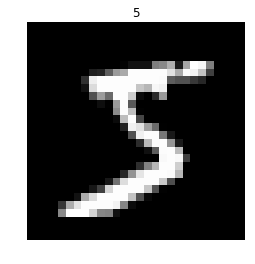

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

batch_gen = next_batch(x_train, y_train, 100)
x_batch, y_batch = batch_gen.__next__()

plt.imshow(np.reshape(x_batch[0],(28,28)), 'gray')
plt.title(str(y_batch[0].argmax()))
plt.axis('off')

# モデル構築

In [5]:
import tensorflow as tf

x_input = tf.placeholder(tf.float32, [None, 784], name='x_input')
y_true = tf.placeholder(tf.float32, [None, 10], name='y_true')

with tf.name_scope('weights'):
    W1 = tf.Variable(tf.random_normal([784, 500], stddev=np.sqrt(2 / (784 + 500))), name='W1')
    W2 = tf.Variable(tf.random_normal([500, 10], stddev=np.sqrt(2 / (500 + 10))), name='W2')
    b1 = tf.Variable(tf.random_normal([500]), name='b1')
    b2 = tf.Variable(tf.random_normal([10]), name='b2')
    h = tf.nn.relu(tf.nn.bias_add(tf.matmul(x_input, W1), b1), name='h')
    y_pred = tf.nn.softmax(tf.nn.bias_add(tf.matmul(h, W2), b2), name='y_pred')

# 損失関数（交差エントロピー）とオプティマイザの定義

In [6]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_true * tf.log(y_pred), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cross_entropy)

# metricの定義

In [7]:
correct_prediction = tf.equal(tf.argmax(y_true, axis=1), tf.argmax(y_pred, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# TensorBoardの準備

In [8]:
from datetime import datetime

tf.summary.histogram("logs/weights1",W1)
tf.summary.histogram("logs/weights2",W2)
tf.summary.histogram("logs/bias1",b1)
tf.summary.histogram("logs/bias2",b2)
tf.summary.scalar("logs/xentropy", cross_entropy)
tf.summary.scalar("logs/accuracy", accuracy)

merged_summary_op = tf.summary.merge_all()

now = datetime.now()
logdir = "tf_logs/.../" + now.strftime("%Y%m%d-%H%M%S") + "/"
summary_writer = tf.summary.FileWriter(logdir)

# 訓練

In [9]:
from tqdm import tqdm

# セッションの開始
sess = tf.InteractiveSession()

# 変数の初期化
sess.run(tf.global_variables_initializer())

# 訓練ループ
for i in tqdm(range(1000)):
    batch_xs, batch_ys = batch_gen.__next__()
    _, summary = sess.run(
        [train_step, merged_summary_op], 
        feed_dict={x_input: batch_xs.astype(np.float32), y_true: batch_ys.astype(np.float32)}
    )
    summary_writer.add_summary(summary, i)

100%|██████████| 1000/1000 [00:22<00:00, 44.50it/s]


# テスト

In [10]:
print(accuracy.eval({x_input: x_test, y_true: y_test}))
print(sess.run(accuracy, feed_dict={x_input: x_test, y_true: y_test}))

0.9632
0.9632


In [11]:
sess.close()